In [1]:
# Initial imports and enviroment setup
import gymnasium as gym
import numpy as np
import sys
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from blackjack.plot_utils import plot_policy, plot_win_rate

# create Blackjack environment
env = gym.make("Blackjack-v1", natural=False, sab=False)

Check [this](https://gymnasium.farama.org/environments/toy_text/blackjack/) for more information about the Blackjack environment. 

In addition, check [this](https://youtu.be/NeusGkowXR4?si=9a1aE_bInK4vSAHw) and [this](https://youtu.be/wn8hlPNwL74?si=PV_h3WQCXmZKwRzW) videos for how the below code is written.

### Action Space

- 0: Stick
- 1: Hit

### Starting State

| **Observation** | **Values** |
| --- | --- |
| Player current sum | $4, 5, \cdots, 21$ |
| Dealer showing card value | $1, 2, \cdots, 11$ |
| Usable Ace | $0, 1$ |

### Rewards

- win game: +1
- lose game: -1
- draw game: 0
- win game with natural blackjack: +1.5 (if `natural` is True) +1 (if `natural` is False)

### Episode End

The episode ends if the following happens:

- Termination:

1. The player hits and the sum of hand exceeds 21.
2. The player sticks.

An ace will always be counted as usable (11) unless it busts the player.

Our Q function will map 3 states to 2 actions, ie, $\text{Q}: \; 3 \text{ states} \; \rightarrow \; 2 \text{ actions}$

Check [this](https://www.geeksforgeeks.org/defaultdict-in-python/) for a refresher on `defaultdict`.

In [1]:
from IPython.display import Image
Image(url="https://gymnasium.farama.org/_images/blackjack.gif")

In [2]:
env.action_space

Discrete(2)

In [3]:
# number of different discrete actions
env.action_space.n

2

In [4]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [5]:
# env.reset()
env.reset()[0]

(19, 10, 1)

In [6]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))

The Q function takes as input the 3 different state values:
- player's current
- dealer's first card
- whether the player has a usable ace

Based on these 3 state values, the Q function returns 2 action values:
- value of action 0, ie, the action-value of playing 'stick'.
- value of action 1, ie, the action-value of playing 'hit'. 

In [7]:
Q[env.reset()[0]]

array([0., 0.])

In [8]:
def epsilon_soft_policy(Q, state, epsilon):
    probs = np.zeros(2)
    # since there are only two actions: 0 and 1
    # so, optimal action is either 0 or 1
    # and, sub-optimal action is the other one 
    optimal_action = np.argmax(Q[state])
    sub_optimal_action = np.abs(optimal_action - 1)
    probs[optimal_action] = 1 - epsilon + epsilon/env.action_space.n
    probs[sub_optimal_action] = epsilon/env.action_space.n
    action = np.random.choice([0,1], p=probs)
    return action


In [9]:
def generate_episode(Q, epsilon):
    state, _ = env.reset()
    episode = []
    while True:
        action = epsilon_soft_policy(Q, state, epsilon)
        next_state, reward, done, trunc, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if (done or trunc):
            break
    return episode


```python
>>> generate_episode(Q, 0.7)
[((16, 10, 1), 1, 0.0), ((16, 10, 0), 0, -1.0)]
```

The output of the above code can be interpreted as follows:
-  ((16, 10, 1), 1, 0.0)
    - This tuple consists of 3 elements:
        1. (16, 10, 1) is a tuple where the 1st element (ie, 16) is the player's current sum, 2nd element (ie, 10) is the dealer's open card value, and 3rd element (ie, 1) tells whether the player has a usable ace or not.
        2. 1 is the action that the player takes
        3. 0.0 is the reward that the player gets after taking the above action (ie, action 1). Reward of 0.0 means that the game was a draw.
-  ((16, 10, 0), 0, -1.0)
    - This tuple consists of 3 elements:
        1. (16, 10, 0) is a tuple where the 1st element (ie, 16) is the player's current sum, 2nd element (ie, 10) is the dealer's open card value, and 3rd element (ie, 0) tells whether the player has a usable ace or not.
        2. 0 is the action that the player takes
        3. -1.0 is the reward that the player gets after taking the above action (ie, action 0). Reward of -1.0 means that the player lost the game.

In [10]:
generate_episode(Q, 0.7)

[((13, 8, 0), 1, 0.0), ((16, 8, 0), 1, -1.0)]

In [11]:
Q

defaultdict(<function __main__.<lambda>()>,
            {(17, 6, 0): array([0., 0.]),
             (13, 8, 0): array([0., 0.]),
             (16, 8, 0): array([0., 0.])})

In [12]:
class Kamal_MC:
    def __init__(self, num_episodes, epsilon, epsilon_min, alpha, decay_rate, gamma):
        """
        param num_episodes: (int) number of episodes to run the algorithm
        param epsilon: (float) 
        param epsilon_min: (float) 
        param alpha: (float)
        param decay_rate: (float)
        param gamma: (float) discount factor
        """
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.alpha = alpha
        self.decay_rate = decay_rate
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.policy = {}
        self.rewards_all_episodes = []

    def monte_carlo_control(self):
        for episode in tqdm(range(1, self.num_episodes + 1)):
            # gradually decrease epsilon until it reaches epsilon_min
            # then keep it constant, i.e., epsilon_min
            self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
            experience = generate_episode(self.Q, self.epsilon)
            states, actions, rewards = zip(*experience)
            rewards = np.array(rewards)
            self.rewards_all_episodes.append(rewards.sum())
            # looping over all of the timesteps 
            for i, state in enumerate(states):
                discounts = np.array([self.gamma**j for j in range(len(rewards[i: ]))])
                returns = sum(rewards[i: ] * discounts)
                # updating the Q_function using the monte carlo constant alpha update rule 
                self.Q[state][actions[i]] += self.alpha * (returns - self.Q[state][actions[i]])
                self.policy = dict((state, np.argmax(q_value)) for state, q_value in self.Q.items())
                        

In [13]:
def fn():
    experience = [(1,2,3), (4,5,6), (7,8,9), (10,11,12), (13,14,15), (16,17,18)]
    states, actions, rewards = zip(*experience)
    print(states)
    print(actions)
    print(rewards)


fn()

(1, 4, 7, 10, 13, 16)
(2, 5, 8, 11, 14, 17)
(3, 6, 9, 12, 15, 18)


In [29]:
# hyperparameters
num_episodes = 50_000
epsilon = 1
epsilon_min = 0.05
alpha = 0.03
decay_rate = 0.9999
gamma = 1

mcc = Kamal_MC(num_episodes, epsilon, epsilon_min, alpha, decay_rate, gamma)

In [30]:
mcc.monte_carlo_control()

100%|██████████| 50000/50000 [01:00<00:00, 831.38it/s] 


In [31]:
sum(mcc.rewards_all_episodes)

-6835.0

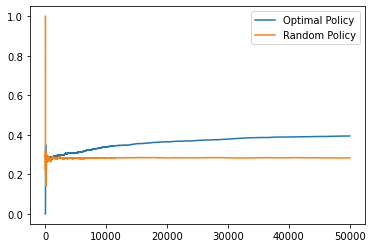

In [32]:
plot_win_rate(mcc.rewards_all_episodes, mcc.num_episodes)

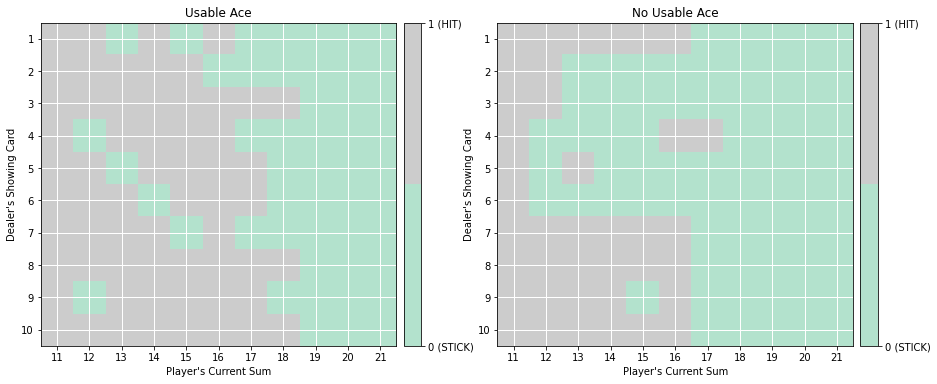

In [33]:
# win_rate of around 42% 
plot_policy(mcc.policy)

![Optimal Policy](./blackjack/optimal.png "Optimal Policy")

In [34]:
class GLIE_MC_Control:
    def __init__(self, num_episodes, epsilon, epsilon_min=0.05, decay_rate=0.9999, gamma=1):
        """
        param num_episodes: (int) number of episodes to run the algorithm
        param epsilon: (float) 
        param epsilon_min: (float)
        param decay_rate: (float)
        param gamma: (float) discount factor
        """
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay_rate = decay_rate
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.visit_count = defaultdict(lambda: np.zeros(env.action_space.n))
        self.policy = defaultdict(lambda: 0)
        self.rewards_all_episodes = []


    def every_visit(self):
        """
        This is the every-visit GLIE Monte Carlo Control algorithm.
        Check pg. 88 of Nimish Sanghi's book for the pseudocode.
        """
        for episode in tqdm(range(1, self.num_episodes+1)):
            experience = generate_episode(self.Q, self.epsilon)
            states, actions, rewards = zip(*experience)
            self.rewards_all_episodes.append(sum(rewards))
            G = 0
            T = len(states)
            for t in range(T-1, -1, -1):
                s, a, r = states[t], actions[t], rewards[t]
                G = self.gamma*G + r
                self.visit_count[s][a] += 1
                self.Q[s][a] = self.Q[s][a] + (1 / self.visit_count[s][a]) * (G - self.Q[s][a])
                for state_value, q_value in self.Q.items():
                    self.policy[state_value] = np.argmax(q_value)
            self.epsilon = self.epsilon/episode


    def first_visit(self):
        """
        This is the first-visit GLIE Monte Carlo Control algorithm.
        """
        pass

In [42]:
# hyperparameters
num_episodes = 50_000
epsilon = 1
epsilon_min = 0.05
decay_rate = 0.9999
gamma = 1

ev_mcc = GLIE_MC_Control(num_episodes, epsilon)

In [43]:
ev_mcc.every_visit()

100%|██████████| 50000/50000 [02:05<00:00, 399.69it/s]


In [44]:
sum(ev_mcc.rewards_all_episodes)

-7681.0

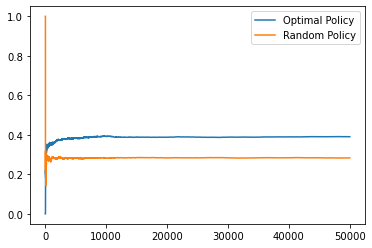

In [45]:
plot_win_rate(ev_mcc.rewards_all_episodes, ev_mcc.num_episodes)

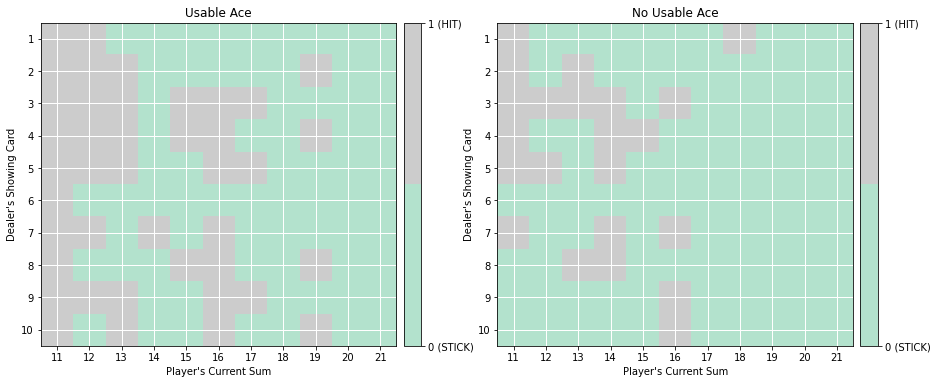

In [46]:
plot_policy(ev_mcc.policy)